In [82]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from scipy.linalg import svd
from matplotlib.pyplot import figure, plot, subplot, title, xlabel, ylabel, show, clim, hist, bar, scatter, contour, contourf, cm
import sklearn.linear_model as lm
import os
from sklearn.metrics import confusion_matrix as cm

from scipy.io import loadmat
import neurolab as nl
from sklearn import model_selection
from scipy import stats

In [2]:
def DataLoader(path, sheet):
    """
    Method for importing data from a spreadsheet.

    :param path: full path to the spreadsheet to load
    :param sheet: name of the sheet in the workbook that is loaded
    :return: pandas dataFrame with imported data
    """
    import pandas as pd

    out = pd.read_excel(path, sheet_name=sheet)

    return out

In [3]:
# Specify path and sheet name in the prostate workbook
filePath = 'C:/Users/PeterBakke/Documents/git/ML_fall2018/Data/Prostate.xlsx'
#filePath = 'C:/Users/Greta/Documents/Github/ML_fall2018/Data/Prostate.xlsx'
#filePath = 'C:/Users/narisa/Documents/GitHub/ML_fall2018/Data/Prostate.xlsx'
sheet = 'Sheet1'

In [4]:
# Load prostate data into dataFrame
myData = DataLoader(path=filePath, sheet=sheet)

# delete irrelevant columns
del myData['ID']
del myData['train']

In [5]:
# Extract class names 
attributeNames = list(myData.columns.values)

# Convert dataFrame to numpy array
X = myData.values

# Compute values of N (observations) and M (features)
M = len(attributeNames)
N = X.shape[0]

print(attributeNames)

['lCaVol', 'lWeight', 'Age', 'lBPH', 'SVI', 'lCP', 'Gleason', 'pgg45', 'lPSA']


In [6]:
# Extracting and deleting PGG45 and Gleason from X, as well as SVI (to not normalize SVI)
X_orig = np.copy(X)

gleason = X_orig[:,6]
pgg = X_orig[:,7]
svi = X_orig[:,4]

# print(X)

In [7]:
# OBS - only run this once
X = np.delete(X,6,1) # Deletes Gleason
X = np.delete(X,6,1) # Deletes PGG
X = np.delete(X,4,1) # Deletes SVI

In [8]:
# Z score all other variables 
X_z = zscore(X)
# print(X_z)

# Current order: lCavol, lWeight, Age, lBPH, lCP, lPSA

In [9]:
# One out of K coding for PGG and Gleason

from categoric2numeric import *

[X_Gleason, attribute_names_Gleason]=categoric2numeric(gleason)
[X_PGG45, attribute_names_PGG45]=categoric2numeric(pgg)

#print(X_Gleason)

In [10]:
# Add one out of K coded Gleason and PGG columns, as well as SVI 
svi = np.reshape(svi,[97,1])
print(svi.shape)
# X_k = np.concatenate((X,X_Gleason,X_PGG45,svi),axis=1)
X_k = np.concatenate((X_z,X_Gleason,svi),axis=1)

print(X_k.shape)
print(X_k[2])

# Order: lCavol, lWeight, Age, lBPH, lCP, lPSA, Gleason (4 columns), (PGG (19 columns)), SVI (1 column)


(97, 1)
(97, 11)
[-1.58702059 -2.20015441  1.36823439 -1.03002898 -0.86765522 -2.29971238
  0.          1.          0.          0.          0.        ]


In [14]:
# Remove attribute 10 (SVI) and Gleason from X
X_classification = X_k[:,[0,1,2,3,4,5,6,7,8,9]]

# Use attribute 10 (SVI) as y
y_classification = X_k[:,10]


In [15]:
N, M = X_classification.shape

print(N)
print(M)

97
10


In [28]:
# Parameters for neural network classifier
n_hidden_units = [2,4,6,8,10,15]      # number of hidden units
n_train = 6             # number of networks trained in each k-fold
learning_goal = 0.00001     # stop criterion 1 (train mse to be reached)
max_epochs = 512         # stop criterion 2 (max epochs in training)
show_error_freq = 1000     # frequency of training status updates

In [29]:
# K-fold crossvalidation
K = 5                   # only three folds to speed up this example
CV = model_selection.KFold(K,shuffle=True)

In [84]:
# Variable for classification error
errors = np.zeros(K)*np.nan
gen_error = np.zeros(K)*np.nan
error_hist = np.zeros((max_epochs,K))*np.nan
bestnet = list()
k=0
for train_index, test_index in CV.split(X_classification,y_classification):
    print('\nCrossvalidation fold: {0}/{1}'.format(k+1,K))    
    
    # extract training and test set for current CV fold
    X_train = X_classification[train_index,:]
    y_train = y_classification[train_index]
    X_test = X_classification[test_index,:]
    y_test = y_classification[test_index]
    
    best_train_error = np.inf
    for i in range(n_train):
        print('Training network {0}/{1}...'.format(i+1,n_train))
        # Create randomly initialized network with 2 layers
        ann = nl.net.newff([[-10,10]]*M, [n_hidden_units[i], 1], [nl.trans.LogSig(),nl.trans.LogSig()])
        if i==0:
            bestnet.append(ann)
        # train network
        train_error = ann.train(X_train, y_train.reshape(-1,1), goal=learning_goal, epochs=max_epochs, show=show_error_freq)
        
        if train_error[-1]<best_train_error:
            bestnet[k]=ann
            best_train_error = train_error[-1]
            error_hist[range(len(train_error)),k] = train_error
            best_no_neurons = n_hidden_units[i]

    print('Best train error: {0}...'.format(best_train_error))
    print('Optimal number of hidden neurons: {0}...'.format(best_no_neurons))
    y_est = bestnet[k].sim(X_test).squeeze()
    y_est = (y_est>.5).astype(int)
    #errors[k] = np.power(y_est-y_test,2).sum().astype(float)/y_test.shape[0]
    errors[k] = 100*(y_est!=y_test).sum().astype(float)/y_test.shape[0]
    gen_error[k] = 100 * (y_est-y_test).sum().astype(float)/y_test.shape[0]
    #errors[k] = - y_test * np.log(y_est) - (1 - y_test) * np.log (1 - y_est)
    print(gen_error[k])
    k+=1
    #break
    




Crossvalidation fold: 1/5
Training network 1/6...
Training network 2/6...
The goal of learning is reached
Training network 3/6...
Training network 4/6...
Training network 5/6...
The goal of learning is reached
Training network 6/6...
The goal of learning is reached
Best train error: 5.961367528382537e-06...
Optimal number of hidden neurons: 4...
0.0

Crossvalidation fold: 2/5
Training network 1/6...
Training network 2/6...
The goal of learning is reached
Training network 3/6...
Training network 4/6...
The goal of learning is reached
Training network 5/6...
The goal of learning is reached
Training network 6/6...
Best train error: 6.437182424716974e-06...
Optimal number of hidden neurons: 8...
-5.0

Crossvalidation fold: 3/5
Training network 1/6...
Training network 2/6...
Training network 3/6...
Training network 4/6...
Training network 5/6...
Training network 6/6...
Best train error: 0.500000418948064...
Optimal number of hidden neurons: 8...
0.0

Crossvalidation fold: 4/5
Training netw

In [85]:
# dummy test of training data error
y_hat = []
dummy_error = []
y_hat = bestnet[0].sim(X_train).squeeze()
y_hat = (y_hat>.5).astype(int)
dummy_error = np.power(y_hat-y_train ,2).astype(float)/y_train.shape[0]

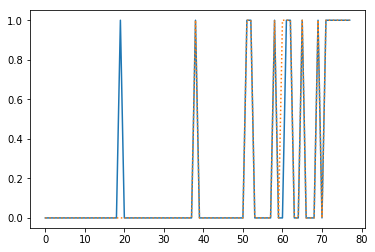

In [86]:
plot(y_hat )
plot(y_train,":")

Mean-square error: 16.57894736842105


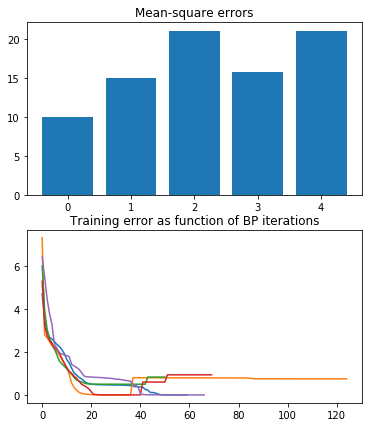

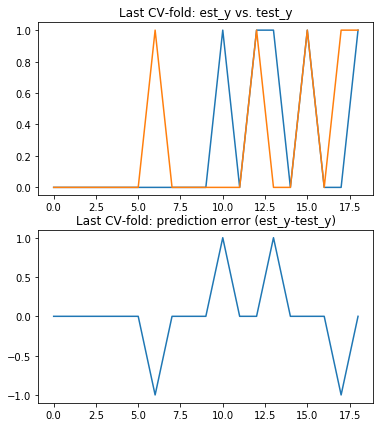

In [87]:
# Print the average least squares error
print('Mean-square error: {0}'.format(np.mean(errors)))

figure(figsize=(6,7));
subplot(2,1,1); bar(range(0,K),errors); title('Mean-square errors');
subplot(2,1,2); plot(error_hist); title('Training error as function of BP iterations');
figure(figsize=(6,7));
subplot(2,1,1); plot(y_est); plot(y_test); title('Last CV-fold: est_y vs. test_y'); 
subplot(2,1,2); plot((y_est-y_test)); title('Last CV-fold: prediction error (est_y-test_y)'); 
show()




C:\Users\PeterBakke\Anaconda3\lib\site-packages\matplotlib\contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


AttributeError: 'function' object has no attribute 'RdBu'

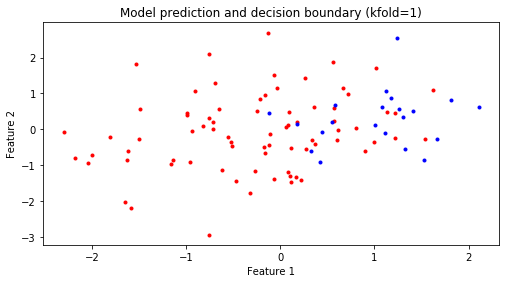

In [83]:
# Display the decision boundary for the several crossvalidation folds.
# (create grid of points, compute network output for each point, color-code and plot).
grid_range = [-1, 2, -1, 2]; delta = 0.05; levels = 100
a = np.arange(grid_range[0],grid_range[1],delta)
b = np.arange(grid_range[2],grid_range[3],delta)
A, B = np.meshgrid(a, b)
values = np.zeros(A.shape)

figure(1,figsize=(18,9))
for k in range(4):
    subplot(2,2,k+1)
    cmask = (y_classification==0).squeeze(); plot(X_classification[cmask,0], X_classification[cmask,1],'.r')
    cmask = (y_classification==1).squeeze(); plot(X_classification[cmask,0], X_classification[cmask,1],'.b')
    title('Model prediction and decision boundary (kfold={0})'.format(k+1))
    xlabel('Feature 1'); ylabel('Feature 2');
    for i in range(len(a)):
        for j in range(len(b)):
            values[i,j] = bestnet[k].sim( np.mat([a[i],b[j]]) )[0,0]
    contour(A, B, values, levels=[.5], colors=['k'], linestyles='dashed')
    contourf(A, B, values, levels=np.linspace(values.min(),values.max(),levels), cmap=cm.RdBu)
    if k==0: colorbar(); legend(['Class A (y=0)', 'Class B (y=1)'])


# Display exemplary networks learning curve (best network of each fold)
figure(2)
bn_id = np.argmax(error_hist[-1,:])
error_hist[error_hist==0] = learning_goal
for bn_id in range(K):
    plot(error_hist[:,bn_id]); xlabel('epoch'); ylabel('train error (mse)'); title('Learning curve (best for each CV fold)')

plot(range(max_epochs), [learning_goal]*max_epochs, '-.')


show()
